# Time series forecasting project

In [1]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima

## 1. Data loading

In [2]:
# Decide what dataset to use
dataset='flights'

### 1.1. Load

In [3]:
if dataset == 'flights':
    raw_data_df=sns.load_dataset("flights")

elif dataset == 'sales':
    raw_data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')

### 1.2. Inspect 

In [4]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [5]:
if dataset == 'sales':

    # Extract the date feature from the raw data as a series of datetime objects
    date_time_series=pd.to_datetime(raw_data_df.date)

    # Set the extracted datetime object as the index on a copy of the raw data
    timeseries_df=raw_data_df.set_index(date_time_series)

    # Then drop the string date column
    timeseries_df.drop('date', axis=1, inplace=True)

    # Re-name 'sales' to 'dependent_var' so we can easily swap datasets without making
    # changes to the notebook
    timeseries_df.rename(columns={'sales': 'dependent_var'}, inplace=True)

if dataset == 'flights':

    # Make a copy of the raw data to work with
    timeseries_df=raw_data_df.copy()

    # Extract the string month to a datetime object feature
    timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

    # Use the month and year to create at 'date' datetime feature
    timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

    # Set the datetime feature as the index
    timeseries_df=timeseries_df.set_index('date')

    # Keep only the passenger column
    timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

    # Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
    # changes to the notebook
    timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model.

In [6]:
# Instantiate a linear model
linear_model=LinearRegression()

# Generate a uniform x variable representing the time steps
x=np.array(range(len(timeseries_df))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, timeseries_df['dependent_var'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
timeseries_df['Linear model']=predictions

# Calculate the root mean squared error
rmse=sqrt(mean_squared_error(timeseries_df['dependent_var'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 45.7


### 2.2. Missing, and/or extreme values

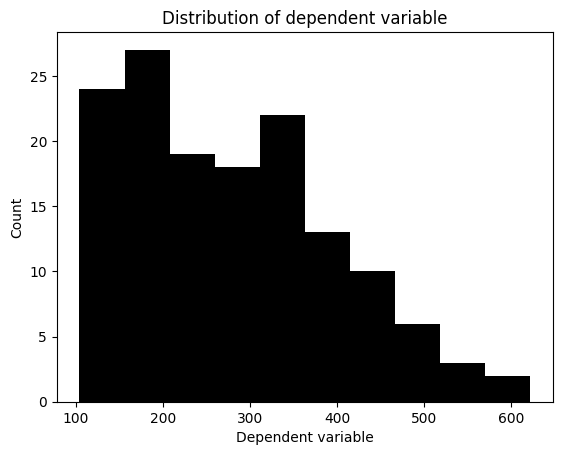

In [7]:
plt.title('Distribution of dependent variable')
plt.hist(timeseries_df['dependent_var'], color='black')
plt.xlabel('Dependent variable')
plt.ylabel('Count')
plt.show()

In [8]:
timeseries_df.describe()

,dependent_var,Linear model
count,144.000000,144.000000
mean,280.298611,280.298611
std,119.966317,110.839929
min,104.000000,90.309962
25%,180.000000,185.304286
50%,265.500000,280.298611
75%,360.500000,375.292936
max,622.000000,470.287261


### 2.3. Timeseries analysis

Let's now take a look at the data as a timeseries. There are a couple of things to look out for here.

1. Is the time axis regular - i.e. are the rows evenly spaced in time.
2. Is the data stationary - i.e. is there a consistent trend over time. The answer to this question will effect how we model the data.
3. Are there regular or cyclical trends - e.g. sales are high on Mondays and low on weekends.

### 2.3.1. Plot the time-series

Let's include predictions from the baseline model too and see what we are working with.

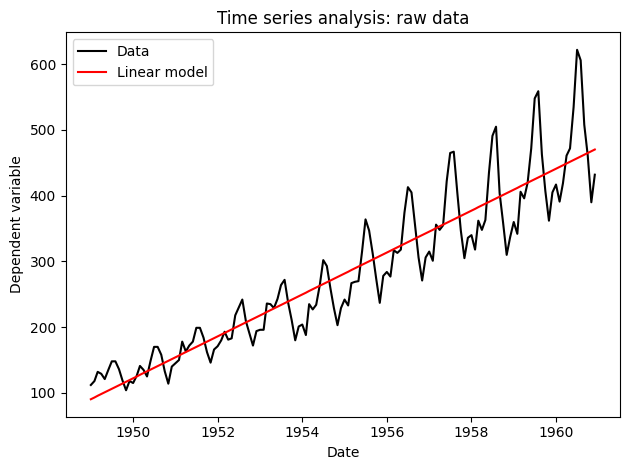

In [9]:
plt.title('Time series analysis: raw data')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(timeseries_df['Linear model'], label='Linear model', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 2.3.2. Missing time points

Next, do a quick check to see if the datetime index we just created is evenly spaced - i.e. the time delta between the rows is always the same.

Datetime axis is regular: False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   Linear model   144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


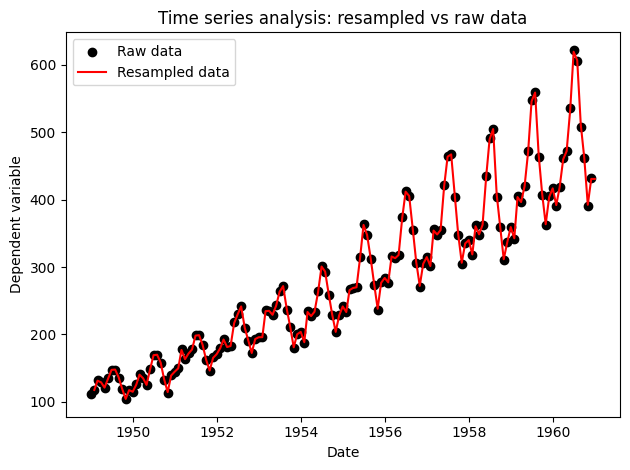

In [10]:
# Take the difference across the datetime index
diff=np.diff(timeseries_df.index.to_numpy())

# Check that all of the differences are equal
equally_spaced=np.all(diff==diff[0])

print(f'Datetime axis is regular: {equally_spaced}')

# If the datetime axis not regular - resample it and fill in the
# missing time points with interpolation
if equally_spaced == False:

    # Resample down to days first
    resampled_timeseries_df=timeseries_df.resample('D').interpolate()

    # Then resample back up to months
    resampled_timeseries_df=resampled_timeseries_df.resample('ME').interpolate()
    resampled_timeseries_df.info()

    # Plot the results to be sure we didn't deform anything too badly...
    plt.title('Time series analysis: resampled vs raw data')
    plt.scatter(timeseries_df.index, timeseries_df['dependent_var'], label='Raw data', color='black')
    plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
    plt.xlabel('Date')
    plt.ylabel('Dependent variable')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    timeseries_df=resampled_timeseries_df

### 2.3.3. Stationarity

The data is obviously non-stationary. But we can check with the Dickey-Fuller test.

In [11]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(timeseries_df['dependent_var'], autolag="AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.984


To make the data stationary, we use differencing:

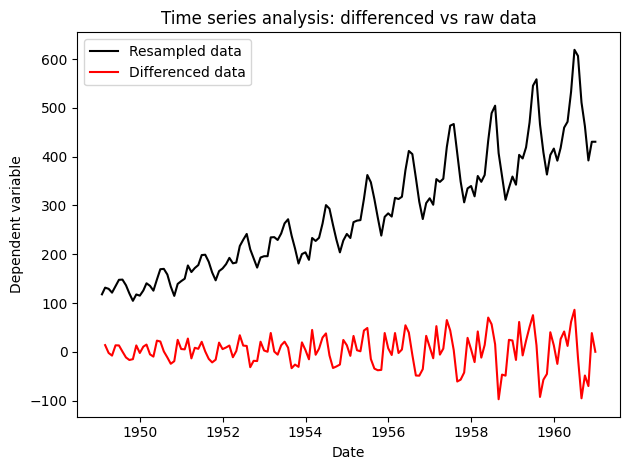

In [12]:
stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('Time series analysis: differenced vs raw data')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='black')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3. Model training

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

timeseries_model=auto_arima(timeseries_df['dependent_var'], seasonal=True, stationary=False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1012.628, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1021.005, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1012.917, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1013.833, Time=0.15 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1012.119, Time=0.71 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1011.298, Time=0.25 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1011.809, Time=0.76 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1016.507, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1016.547, Time=0.10 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=1012.999, Time=0.25 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1014.559, Time=0.06 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=1010.846, Time=0.29 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=1010.976, Time=0.49 sec
 ARIMA(1,1,3)(0,1,1)[12]

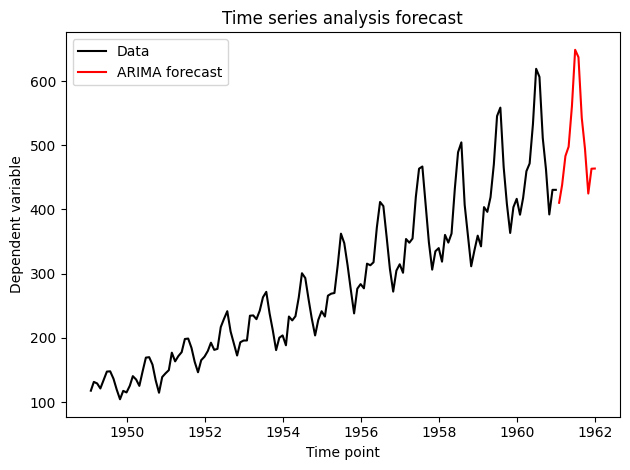

In [14]:
# Make predictions for the next 12 time points into the future
forecast=timeseries_model.predict(12)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='ARIMA forecast', color='red')
plt.xlabel('Time point')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Looks great right? But be careful, can you see what is happening? Try making the following plot!

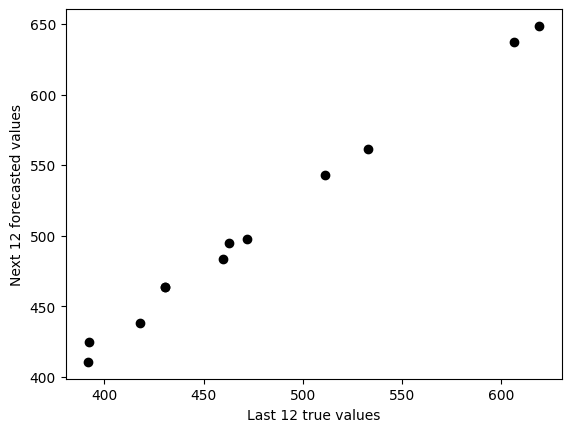

In [15]:
# Get the last 12 time points from the real data
true_data=timeseries_df['dependent_var'][-12:]

# Plot them against the predictions
plt.scatter(true_data, forecast, color='black')
plt.xlabel('Last 12 true values')
plt.ylabel('Next 12 forecasted values')
plt.show()

If you still don't see it - try forcasting farther into the future...

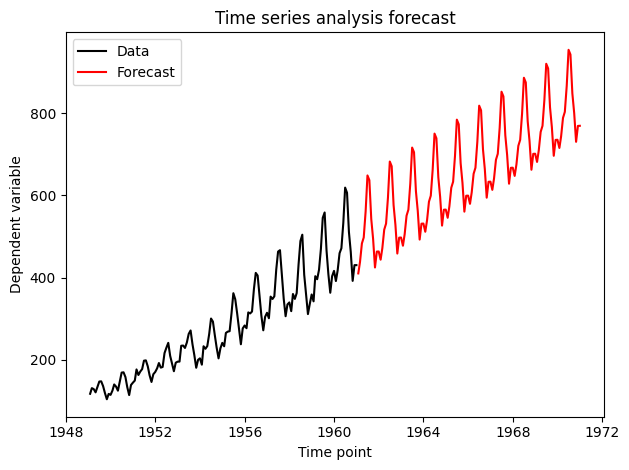

In [16]:
# Make predictions for the next 120 time points into the future
forecast=timeseries_model.predict(120)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Time point')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The model is just regurgitating the last year or so of data over and over again!

## 4. Model evaluation

This result *looks* convincing, at least if you don't look too close - but how well are we actually doing? We need to implement test-train splitting and/or cross-validation to estimate the actual performance on unseen data!

Breaking up time-series data is a little bit harder than other types of tabular data - we can't just randomly select data points for the training and/or validation sets because the order matters!

Luckily, Scikit-learn can help us out here - take a look at [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [17]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon=6

# Set a model order, i.e. how many past data points should be used as input for prediction
model_order=36

### 4.1. Test-train split

In [18]:
# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(timeseries_df) - testing_dataset_size

# Get the training and testing sets
training_data=timeseries_df[:training_set_size]
testing_data=timeseries_df[training_set_size:]

### 4.2. Cross-validation

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=175.666, Time=0.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=178.796, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=171.344, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=175.555, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=251.740, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=170.231, Time=0.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=171.392, Time=0.15 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=173.276, Time=0.58 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=171.868, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=171.995, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=173.796, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=173.827, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=176.232, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 2.702 seconds
Performing stepwise s

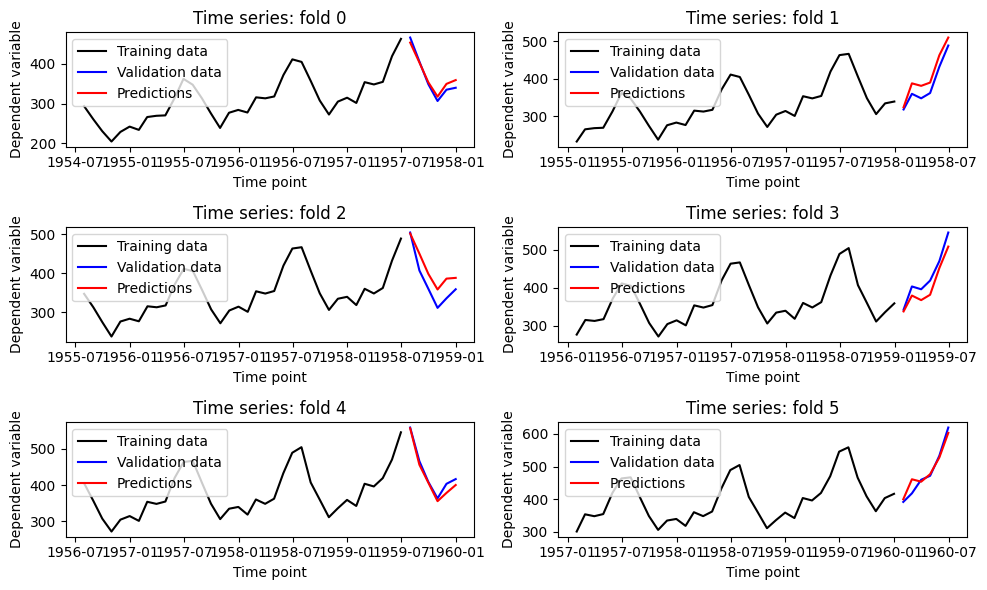

In [19]:
# Number of 'cross-validation' folds to run
folds=6

# Holders to collect data for later
validation_rmse_values=[]
predicted_values=[]
validation_values=[]

# Set-up a multiplot for the results
fig, axs=plt.subplots(3, 2, figsize=(10,6))
axs=axs.flatten()

# Instantiate a time series splitter
timeseries_splits=TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Loop on the splits with a counter
for i, timeseries_split in enumerate(timeseries_splits.split(training_data)):

    # Recover the split indices
    training_indices=timeseries_split[0]
    validation_indices=timeseries_split[1]

    # Get the data for this split from the training data
    fold_training_data=training_data.iloc[training_indices, :]
    fold_validation_data=training_data.iloc[validation_indices, :]

    # Fit the model and predict out to the forecast horizon
    timeseries_model=auto_arima(fold_training_data['dependent_var'], stationary=False, trace=True, seasonal=True, m=12, suppress_warnings=True)
    forecast=timeseries_model.predict(forecast_horizon)

    # Collect intermediate results
    predicted_values.extend(forecast)
    validation_values.extend(fold_validation_data['dependent_var'])

    rmse=sqrt(mean_squared_error(fold_validation_data['dependent_var'], forecast))
    validation_rmse_values.append(rmse)

    # Draw the timeseries plot for this fold
    axs[i].set_title(f'Time series: fold {i}')
    axs[i].plot(fold_training_data['dependent_var'], label='Training data', color='black')
    axs[i].plot(fold_validation_data['dependent_var'], label='Validation data', color='blue')
    axs[i].plot(forecast, label='Predictions', color='red')
    axs[i].set_xlabel('Time point')
    axs[i].set_ylabel('Dependent variable')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()

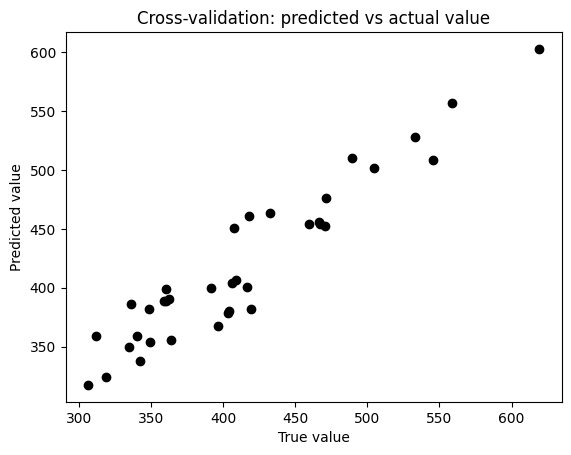

In [20]:
# Plot the forecasted values against the true values
plt.title('Cross-validation: predicted vs actual value')
plt.scatter(validation_values, predicted_values, color='black')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [21]:
print(f'Cross-validation RMSE: {np.mean(validation_rmse_values):.1f}+/-{np.std(validation_rmse_values):.1f}')
rmse_results['ARIMA cross-validation mean']=np.mean(validation_rmse_values)

Cross-validation RMSE: 22.8+/-9.1


#### 4.2. Model evaluation

In [22]:
timeseries_model=auto_arima(training_data['dependent_var'], stationary=False, seasonal=True, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=969.238, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=961.838, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=962.689, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=961.254, Time=0.06 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=962.205, Time=0.18 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=963.026, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=962.740, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=961.930, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=964.709, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=962.832, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 3.978 seconds


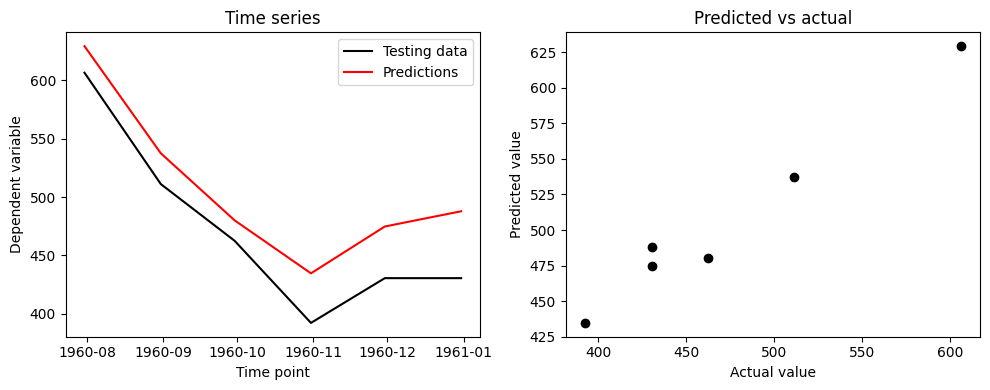

In [23]:
# Make predictions
forecast=timeseries_model.predict(forecast_horizon)

# Plot the result
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,4))

ax1.set_title('Time series')
ax1.plot(testing_data['dependent_var'], label='Testing data', color='black')
ax1.plot(forecast, label='Predictions', color='red')
ax1.set_xlabel('Time point')
ax1.set_ylabel('Dependent variable')
ax1.legend(loc='best')

ax2.set_title('Predicted vs actual')
ax2.scatter(testing_data['dependent_var'], forecast, color='black')
ax2.set_xlabel('Actual value')
ax2.set_ylabel('Predicted value')

plt.tight_layout()
plt.show()

In [24]:
# Calculate RMSE on test set
rmse=sqrt(mean_squared_error(testing_data['dependent_var'], forecast))
rmse_results['ARIMA test data']=rmse

print(f'Root mean square error:')

for experiment, rmse in rmse_results.items():
    print(f'  {experiment}: {rmse:.1f}')

Root mean square error:
  Linear model: 45.7
  ARIMA cross-validation mean: 22.8
  ARIMA test data: 37.8
